# Hydrological data for Ricanau Mofo

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import warnings
import calendar
import math
from scipy import integrate

import pymannkendall as mk
warnings.simplefilter("ignore")  # filter some warning messages

## Precipitation

![Stations_ricanaumofo.png](Stations_ricanaumofo.png)

| Location            	| Source         	| Data              	| Start dataset 	| End dataset 	| Measurement   period 	| Comment                                                                                                      	|
|---------------------	|----------------	|-------------------	|---------------	|-------------	|----------------------	|--------------------------------------------------------------------------------------------------------------	|
| Moengo    	| MDS            	| Evaporation       	| 06-06-2022    	| 31-08-2023  	| 10 minutes           	| Evaporation   calculated from measured Relative Humidity,  Air temperature, Solar radiation   and Wind speed 	|
| Moengo    	| MDS            	| Precipitation     	| 06-06-2022    	| 31-08-2023  	| 10 minutes           	| Not yet available.   Can be requested at MDS                                                                 	|
| Ricanau Mofo        	| AdeK, TU Delft 	| Flow velocity     	| 10-10-2023    	| 29-10-2023  	| 5 minutes            	| Measurements   performed during  MDP                                                                         	|
| Ricanau Mofo        	| MAS, TU Delft  	| River bed profile 	| 29-09-2023    	| 29-09-2023  	| -                    	| Measurements   performed during MDP                                                                          	|
| Nickerie            	| KNMI           	| Precipitation     	| 01-04-1960    	| 31-05-2023  	| Daily                	| Not used for this   research                                                                                 	|
| Zanderij            	| KNMI           	| Precipitation     	| 01-04-1960    	| 31-05-2023  	| Daily                	| -                                                                                                            	|
| Zorg en Hoop        	| KNMI           	| Precipitation     	| 01-04-1960    	| 31-05-2023  	| Daily                	| -                                                                                                            	|
| Moengo    	| MAS            	| Water level       	| 03-11-2023    	| 26-09-2023  	| 10 minutes           	| -                                                                                                            	|
| Bakasroisi          	| MAS            	| Water level       	| 26-07-2019    	| 26-09-2023  	| 10 minutes           	| -                                                                                                            	|

**MDS**: Meteorologische Dienst Suriname;
**MAS**: Maritieme Authoriteit Suriname;
**KNMI**: Koninklijk Nederlands Meteorologisch Instituut;
**AdeK**: Anton de Kom Universiteit
 

,Nickerie,Zanderij,Zorg en Hoop,Ricanau Mofo
count,21459.000000,21208.000000,20923.000000,42131.000000
mean,4.751890,6.199137,5.929210,6.065087
std,11.011224,10.953083,11.513324,11.235479
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.200000,1.300000,0.800000,1.000000
75%,4.200000,7.800000,6.800000,7.300000
max,176.000000,145.100000,144.200000,145.100000


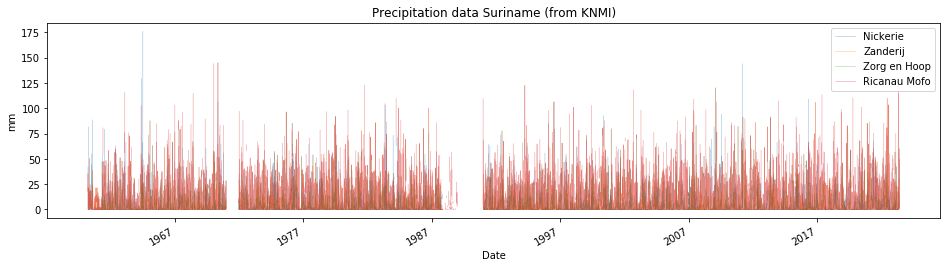

In [2]:
# Load Excel file
xls = pd.ExcelFile('Prec_Kust_Suriname_KNMI.xlsx')

# Location of weather stations
loc = ['Nickerie', 'Zanderij', 'Zorg en Hoop']

# Define a list of DataFrames
pr = pd.DataFrame()

# Apply transformations to each DataFrame in the list
for i in range(3):
    pr_station = pd.read_excel(xls, loc[i])
    pr_station = pr_station.melt(id_vars=["jaar", "maand"], var_name="dag", value_name=loc[i])
    pr_station = pr_station.rename(columns={'jaar': 'year', 'maand': 'month', 'dag': 'day'})
    pr_station['day'] = pr_station.apply(lambda row: min(row['day'], pd.Timestamp(f"{row['year']}-{row['month']}-1").days_in_month), axis=1)
    pr_station['Date'] = pd.to_datetime(pr_station[['year', 'month', 'day']])
    pr_station = pr_station.drop(['year', 'month', 'day'], axis=1)
    pr_station.set_index('Date', inplace=True)
    pr = pd.concat([pr, pr_station], ignore_index=False)
    
pr.replace([-999, "ED"], pd.NA, inplace=True)
pr = pr.apply(pd.to_numeric, errors='coerce')

# Calculate the mean of "Zanderij" and "Zorg en Hoop" columns and create a new column "Ricanau Mofo"
pr['Ricanau Mofo'] = pr[['Zanderij', 'Zorg en Hoop']].mean(axis=1)
 
display(pr.describe())
pr.plot(title='Precipitation data Suriname (from KNMI)',
        ylabel='mm',
        figsize=(16,4),
        linewidth=.5,
       alpha=.5);

As there is no wheater station in Ricanau Mofo, the precipitation is simplified as being the mean of stations _Zanderij_ and _Zorg & Hoop_.

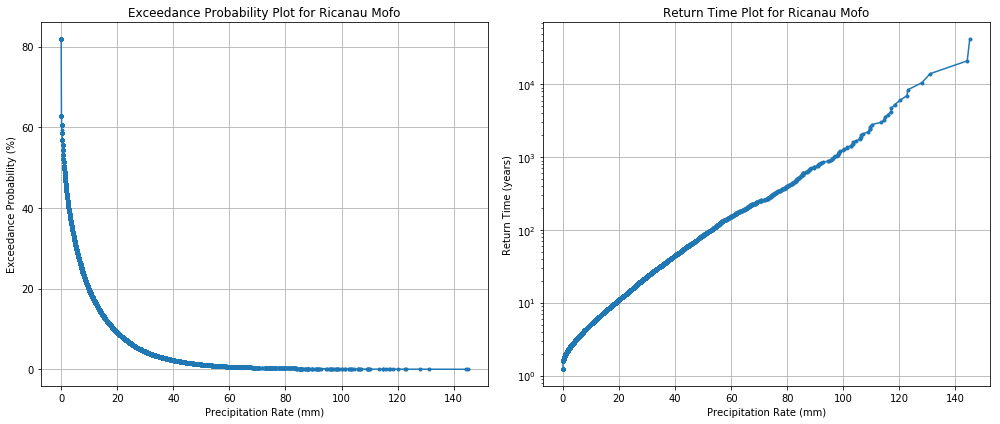

In [3]:
import matplotlib.pyplot as plt

# Filter out zero values from the 'Ricanau Mofo' column
filtered_data = pr[pr['Ricanau Mofo'] >= 0]

# Sort the filtered data in descending order
rica_sorted = filtered_data['Ricanau Mofo'].sort_values(ascending=False)

# Calculate the exceedance probability for the filtered data
exceedance_prob = (1 - (rica_sorted.rank() - 1) / len(rica_sorted)) * 100

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the exceedance probability with a log scale on the x-axis
ax1.plot(rica_sorted, exceedance_prob, marker='o', markersize=3, linestyle='-')
ax1.set_xlabel('Precipitation Rate (mm)')
ax1.set_ylabel('Exceedance Probability (%)')
ax1.set_title('Exceedance Probability Plot for Ricanau Mofo')
ax1.grid(True)

# Calculate the return time (inverse of exceedance probability) for the filtered data
return_time = 1 / (exceedance_prob / 100)  # Convert exceedance probability to a fraction

# Plot the return time
ax2.plot(rica_sorted, return_time, marker='o', markersize=3, linestyle='-')
ax2.set_xlabel('Precipitation Rate (mm)')
ax2.set_ylabel('Return Time (years)')
ax2.set_title('Return Time Plot for Ricanau Mofo')
ax2.set_yscale('log')  # Set the x-axis to logarithmic scale

ax2.grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


Left we can see the exceedance probability of precipitation in Ricanau Mofo. Right we can see the return time of rainfall events. Interpolation can be tricky as the uncertainty of these projections can be very high. 

El Niño and La Niña can affect these heavy rain events. Understanding these patterns helps us predict when extreme rain might happen. These effects are not taken into account in this research.

As flood mostly occur during the months May and June, we will look into these months only now.

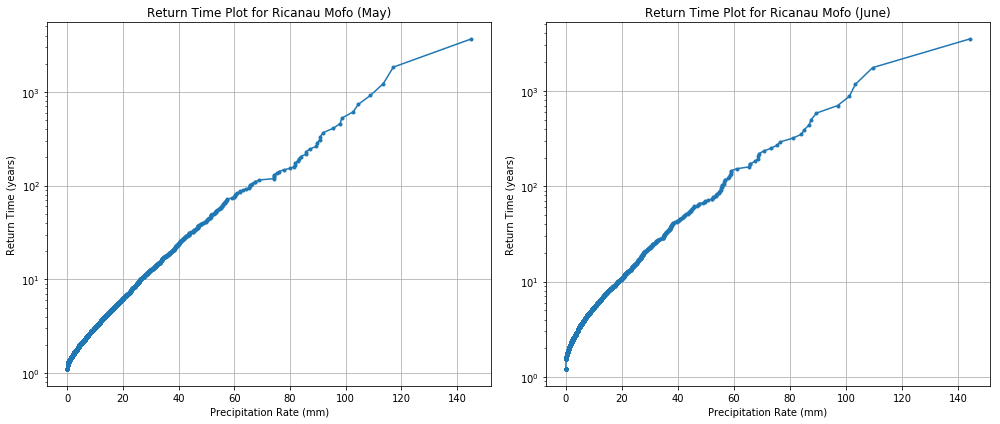

In [4]:
import matplotlib.pyplot as plt

# Filter out zero values from the 'Ricanau Mofo' column
filtered_data = pr[pr['Ricanau Mofo'] >= 0]

# Filter data for the month of May
may_data = filtered_data[filtered_data.index.month == 5]

# Filter data for the month of June
june_data = filtered_data[filtered_data.index.month == 1]

# Sort the filtered data in descending order for May and June
rica_sorted_may = may_data['Ricanau Mofo'].sort_values(ascending=False)
rica_sorted_june = june_data['Ricanau Mofo'].sort_values(ascending=False)

# Calculate the exceedance probability for May and June data
exceedance_prob_may = (1 - (rica_sorted_may.rank() - 1) / len(rica_sorted_may)) * 100
exceedance_prob_june = (1 - (rica_sorted_june.rank() - 1) / len(rica_sorted_june)) * 100

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the return time for May data
ax1.plot(rica_sorted_may, 1 / (exceedance_prob_may / 100), marker='o', markersize=3, linestyle='-')
ax1.set_xlabel('Precipitation Rate (mm)')
ax1.set_ylabel('Return Time (years)')
ax1.set_title('Return Time Plot for Ricanau Mofo (May)')
ax1.set_yscale('log')  # Set the y-axis to logarithmic scale
ax1.grid(True)

# Plot the return time for June data
ax2.plot(rica_sorted_june, 1 / (exceedance_prob_june / 100), marker='o', markersize=3, linestyle='-')
ax2.set_xlabel('Precipitation Rate (mm)')
ax2.set_ylabel('Return Time (years)')
ax2.set_title('Return Time Plot for Ricanau Mofo (June)')
ax2.set_yscale('log')  # Set the y-axis to logarithmic scale
ax2.grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()


The months May and June do not seem to differ too much, therefore we take them back together in the next visualization. Because floods occur after multiple days of heavy rain, we're interested in the rolling mean of several days (3 for now). In this way we can indicate what is the return time of floods in Ricanau Mofo

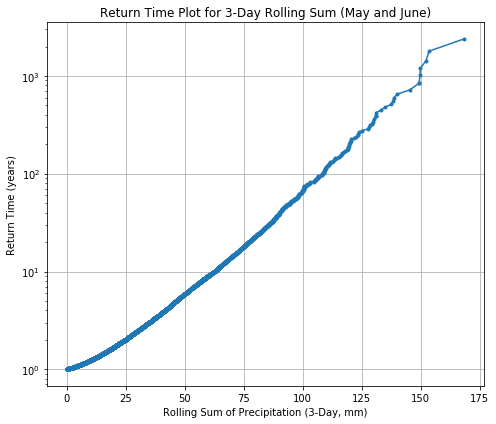

In [5]:
import matplotlib.pyplot as plt

# Filter out zero values from the 'Ricanau Mofo' column
filtered_data = pr[pr['Ricanau Mofo'] >= 0]

# Filter data for the months of May and June
may_june_data = filtered_data[(filtered_data.index.month == 5) | (filtered_data.index.month == 6)]

# Calculate the rolling sum of 3 days for May and June data
rolling_sum_may_june = may_june_data['Ricanau Mofo'].rolling(window=3).sum()

# Sort the filtered and rolling sum data in descending order
rica_sorted_may_june = rolling_sum_may_june.sort_values(ascending=False)

# Calculate the exceedance probability for May and June data
exceedance_prob_may_june = (1 - (rica_sorted_may_june.rank() - 1) / len(rica_sorted_may_june)) * 100

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the return time for May and June data
ax.plot(rica_sorted_may_june, 1 / (exceedance_prob_may_june / 100), marker='o', markersize=3, linestyle='-')
ax.set_xlabel('Rolling Sum of Precipitation (3-Day, mm)')
ax.set_ylabel('Return Time (years)')
ax.set_title('Return Time Plot for 3-Day Rolling Sum (May and June)')
ax.set_yscale('log')  # Set the y-axis to logarithmic scale
ax.grid(True)


plt.tight_layout()  # Ensure proper spacing in the plot
plt.show()

Based on villagers' stories, it appears that Ricanau Mofo copes with floods approximately once in a year/two years. In the context of the return time plot for the 3-day rolling sum of precipitation, the value of 25 mm represents a critical threshold. When the rolling sum of precipitation exceeds 25 mm, it's likely to lead to flooding events, occurring approximately once every two years, as suggested by the data.

We must empathise that these are very rough estimates

### Seasonal fluctuations

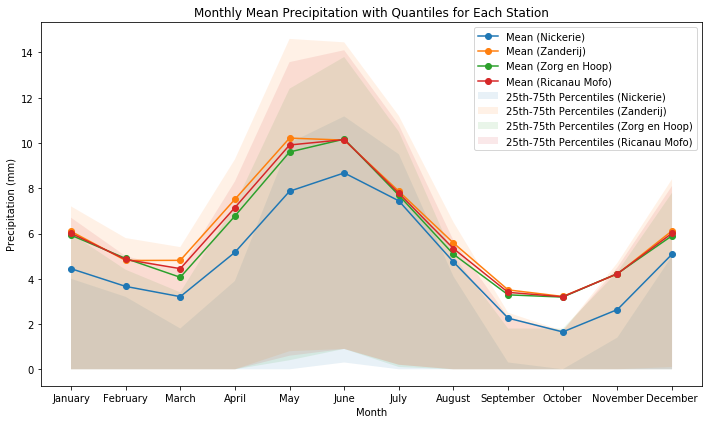

In [6]:
# Group by months and calculate mean precipitation for each station
pr_month_mean = pr.groupby(pr.index.month).mean()
pr_month_25 = pr.groupby(pr.index.month).quantile(0.25)
pr_month_75 = pr.groupby(pr.index.month).quantile(0.75)

# Rename the index column to "Month"
pr_month_mean.index.rename("Month", inplace=True)

# Set the indexes to be the individual months
pr_month_mean.index = pd.to_datetime(pr_month_mean.index, format='%m').strftime('%B')

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the mean precipitation for each station
for station in pr.columns:
    plt.plot(pr_month_mean.index, pr_month_mean[station], label=f'Mean ({station})', marker='o')

    # Plot the 25th and 75th percentiles for each station as shaded areas
    plt.fill_between(pr_month_mean.index, pr_month_25[station], pr_month_75[station], alpha=0.1, label=f'25th-75th Percentiles ({station})')

# Add labels and title
plt.title('Monthly Mean Precipitation with Quantiles for Each Station')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')

# Display legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


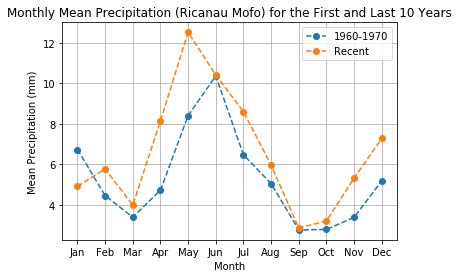

In [7]:
# Filter the data for the first and last 10 years
first_10_years = pr['Ricanau Mofo'].loc['1961-01-01':'1971-12-31']
last_10_years = pr['Ricanau Mofo'].loc['2013-01-01':'2022-12-31']

# Calculate the monthly means for each period
first_10_years_monthly_mean = first_10_years.groupby(first_10_years.index.month).mean()
last_10_years_monthly_mean = last_10_years.groupby(last_10_years.index.month).mean()

# Plot the monthly mean values for the first and last 10 years
plt.plot(first_10_years_monthly_mean.index, first_10_years_monthly_mean.values, label='1960-1970', marker='o', linestyle='--')
plt.plot(last_10_years_monthly_mean.index, last_10_years_monthly_mean.values, label='Recent', marker='o', linestyle='--')

plt.title('Monthly Mean Precipitation (Ricanau Mofo) for the First and Last 10 Years')
plt.xlabel('Month')
plt.ylabel('Mean Precipitation (mm)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

From this graph we can see that the long rainy season has gotten a little earlier in the year. Also, the sort rainy and dry season seems to be less predictable than it was in the 60s.

### Trend Analysis

Trends in precipitation time series can be investigated using different (extreme) indices. The ETCCDI (Expert Team on Climate Change Detection Indices) made a recommendation of suitable climatic extreme indices for daily values of precipitation.

We will calculate trends in total annual precipitation, annual maximum precipitation, and the annual count of days/cases when precipitation exceeds 20 mm.

In [8]:
pr_total_annual = pr.resample("A").sum()
pr_max_annual = pr.resample("A").max()

# Calculate amount of days pr > 20 mm
pr_20mm = (pr["Ricanau Mofo"] > 20).to_frame()  # returns boolean
pr_20mm.drop(pr_20mm[pr_20mm["Ricanau Mofo"] == False].index, inplace=True)  # drop False
pr_20mm = pr_20mm.astype(int)  # convert True to 1
pr_20mm = pr_20mm.resample("A").sum()  # Resample to yearly counts

To calculate trends based on the indices the non-parametric Mann-Kendall (M-K) test (Kendall, 1955; Mann, 1945) can be used. The M-K test is selected by the WMO in order to examine the significance of trends in precipitation data time series. It is important that data should contain no serial correlation (autocorrelation). In this notebook we will use the pyMannKendall package (Hussain and Mahmud (2019)). You can find more info on Github (https://github.com/mmhs013/pyMannKendall)

In [9]:
def perform_mk_test(data, alpha=0.05):
    try:
        result = mk.original_test(data, alpha=alpha)
        return result
    except ZeroDivisionError:
        print(f"Cannot perform M-K test on data with no variability.")
        return None

# Apply the M-K test with error handling
result_annual = perform_mk_test(pr_total_annual['Ricanau Mofo'])
result_max_annual = perform_mk_test(pr_max_annual['Ricanau Mofo'])
result_20mm = perform_mk_test(pr_20mm['Ricanau Mofo'])

Cannot perform M-K test on data with no variability.


In [10]:
def annual_tot_pr(df, season):
    """Function to calculate the annual total precipitation
        per season.

    Parameters
    ----------
    df: pd dataframe
        Pandas dataframe containing the observations: in our case
        the daily evaporation values
    season: string
        Based on the period specify: short rain season (SR), long rain season (LR),
        short dry season (SD), long dry season (LD) or full year

    Returns
    -------
    df2: pd dataframe
        A dataframe containing the annual total evaporation for the specified season.
    """

    if season == "SR":
        sub = df.loc[
            (df.index.month == 12) | (df.index.month == 1)
        ]
    elif season == "LD":
        sub = df.loc[(df.index.month >= 2) & (df.index.month <= 4)]
    elif season == "LR":
        sub = df.loc[(df.index.month >= 5) & (df.index.month <= 7)]
    elif season == "SD":
        sub = df.loc[(df.index.month >= 8) & (df.index.month <= 11)]
    elif season == "full_year":
        sub = df

    df2 = pd.DataFrame()
    df2["mean_annual_pr"] = sub["Ricanau Mofo"].resample("A").mean()
    return df2

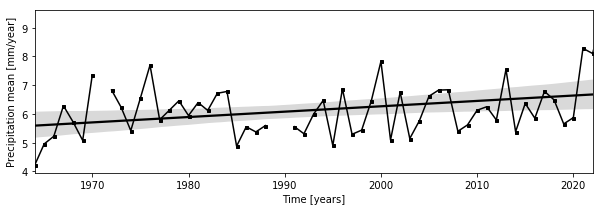

In [11]:
# plot the annual total evaporation and with the linear trendline using the seaborn package
mean_annual_pr = annual_tot_pr(pr, "full_year")
mean_SR_pr = annual_tot_pr(pr, "SR")
mean_LD_pr = annual_tot_pr(pr, "LD")
mean_LR_pr = annual_tot_pr(pr, "LR")
mean_SD_pr = annual_tot_pr(pr, "SD")

plt.figure(figsize=(10, 3))
plt.plot(
    mean_annual_pr.index.year,
    mean_annual_pr.mean_annual_pr,
    marker="s",
    color="k",
    markersize=3,
)

sns.regplot(
    x=mean_annual_pr.index.year,
    y=mean_annual_pr.mean_annual_pr,
    data=mean_annual_pr,
    scatter=False,
    color="k",
    label="linear fit",
)

plt.ylabel("Precipitation mean [mm/year]")
plt.xlabel("Time [years]")
plt.xlim([1964, 2022]);

In [12]:
# check whether a trend exists in the full year time series
perform_mk_test(mean_annual_pr)

Mann_Kendall_Test(trend='increasing', h=True, p=0.009123237675514373, z=2.607401267709524, Tau=0.22950819672131148, s=420.0, var_s=25823.333333333332, slope=0.016435434402942317, intercept=5.4494114866207095)

**Trend** The analysis suggests that there is a statistically significant increasing trend in the precipitation data. This means that over the given time period, the precipitation levels have been on the rise.

**Significance** The p-value of 0.0091 indicates that the observed trend is statistically significant at the chosen level of significance, which suggests that the increasing trend is unlikely to have occurred by random chance.

**Test Statistic (Z)** The test statistic Z is 2.607, which quantifies the strength of the trend. A positive Z value supports the increasing trend.

**Kendall's Tau (Tau)** The calculated Kendall's Tau value is 0.2295, indicating the strength and direction of the trend. A positive Tau value also confirms the increasing trend.

**Number of Data Points (n)** The analysis is based on a dataset with 420 data points, representing the sample size.

**Variance of Tau** This value is 25823.33 and is a measure of the variability of Tau. It helps assess the reliability of the trend estimate.

Linear Regression** The linear regression results show a slope of 0.0164 and an intercept of 5.4494. This means that the linear model representing the trend indicates an increase of approximately 0.0164 units of precipitation per unit of time, starting at 5.4494 units of precipitation.

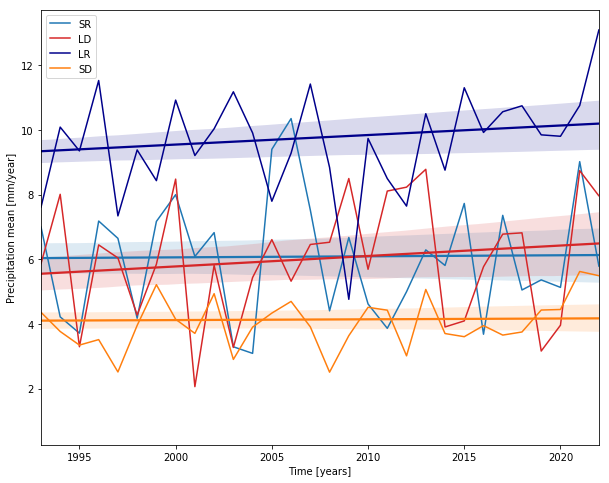

In [13]:
# plot data per season
plt.figure(figsize=(10, 8))

color = ['C0', 'C3', 'darkblue', 'C1']
season = ['SR', 'LD', 'LR', 'SD']

for i in range(4):
    mean_season_pr = annual_tot_pr(pr, season[i])
    
    plt.plot(
    mean_season_pr.index.year,
    mean_season_pr.mean_annual_pr,
    color=color[i],
    label=season[i],
    markersize=3,
    )
    
    sns.regplot(
    x=mean_season_pr.index.year,
    y=mean_season_pr.mean_annual_pr,
    data=mean_season_pr,
    scatter=False,
    color=color[i],
    )

plt.ylabel("Precipitation mean [mm/year]")
plt.xlabel("Time [years]")
plt.xlim([1993, 2022])
plt.legend();

Recent years of precipitation data for Suriname reveal a remarkable alteration in the historical pattern of rainfall distribution across the traditional dry and rainy seasons. Contrary to the conventional seasonal expectations, it has become evident that the long dry season is now characterized by higher mean rainfall levels compared to the long short rainy season. This shift in rainfall patterns aligns with the findings of climate scientists and is consistent with the conclusions drawn by the Intergovernmental Panel on Climate Change (IPCC) in their Fifth Assessment Report (AR5) and Sixth Assessment Report (AR6). These reports discuss how altered temperature and atmospheric conditions, driven by climate change, can lead to unexpected changes in seasonal weather patterns, including shifts in rainfall distribution. Furthermore, regional climate studies, as published in journals like "Climate Dynamics" and "Regional Environmental Change," have explored the changing climate patterns in South America, including Suriname, and have emphasized the unpredictability of traditional seasonal boundaries.

## Evaporation

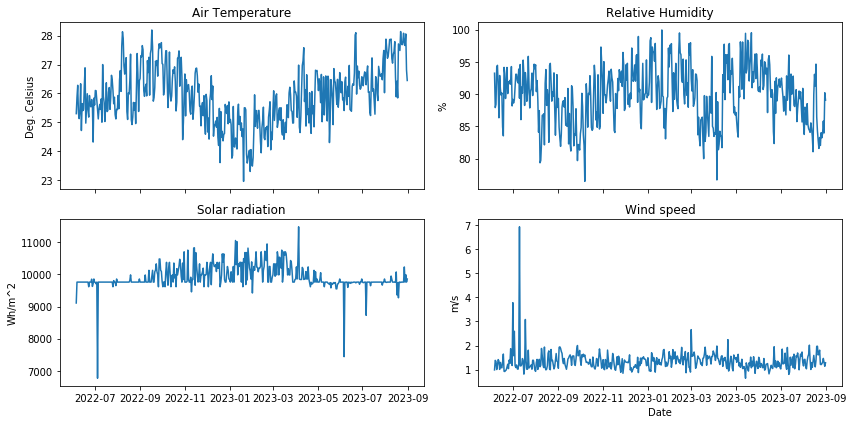

In [14]:
# Load the Excel file into a DataFrame
evap = pd.read_excel('Meteo_Moengo.xlsx')

#  Extract the name and unit from the second and third rows
names = evap.iloc[0, 1:5]  
units = evap.iloc[1, 1:5] 

# Drop name and unit
evap = evap.drop([0, 1])

# Assuming the first column contains dates, convert it to datetime
evap['Date'] = pd.to_datetime(evap['Date'], format='%Y-%m-%d')  # You might need to adjust the date format

# Set the 'Date' column as the index
evap.set_index('Date', inplace=True)

# Get a list of variable names from the DataFrame columns
variable_names = evap.columns

# Determine the number of subplots based on the number of variables
num_subplots = len(variable_names)

# Create subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Loop through the variables and create subplots
for i in range(num_subplots):
    axs[i].plot(evap.index, evap[variable_names[i]])
    axs[i].set_title(names[i])
    axs[i].set_ylabel(units[i])

# Set common X-axis label
axs[-1].set_xlabel('Date')

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

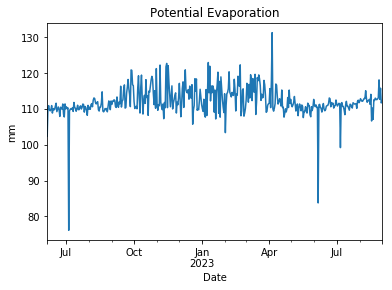

In [15]:
# Constants
α = 0.13 # Albedo coefficient of tropical rainforest in the Amazon
psychometric_constant = 0.063  # Psychrometric constant (hPa/°C)
latent_heat_of_vaporization = 2.45  # Latent heat of vaporization (MJ/kg)
Stefan_Boltzmann_constant = 4.9e-3 # J d-1 m-2 K-4),

# Function to calculate Rn for a single row of the DataFrame
def calculate_ra(row):
    return 245 / (0.5 * row['vw'] + 0.5) / 86400
evap['ra'] = evap.apply(calculate_ra, axis=1)

# Function to calculate e_s for a single row of the DataFrame
def calculate_e_s(row):
    return 0.61 * math.exp((19.9 * row['T']) / (row['T'] + 273.15))
evap['e_s'] = evap.apply(calculate_e_s, axis=1)

# Function to calculate e_a for a single row of the DataFrame
def calculate_e_a(row):
    return row['e_s'] * (row['RH'] /100)
evap['e_a'] = evap.apply(calculate_e_a, axis=1)

def calculate_R_ln(row):
    return Stefan_Boltzmann_constant * (273 + row['T'])**4 * (0.47 - 0.21 * row['e_a']**(1/2)) * (0.2 + 0.8 *0.5)
evap['R_ln'] = evap.apply(calculate_R_ln, axis=1)

# Function to calculate Rn for a single row of the DataFrame
def calculate_Rn(row):
    return (1 - α) * row['Rin'] * 3600 / 86400
evap['Rn'] = evap.apply(calculate_Rn, axis=1)

# Function to calculate PET for a single row of the DataFrame
def calculate_Ep(row):
    T_kelvin = row['T'] + 273.15
    delta = (5430 * row['e_s']) / (T_kelvin ** 2)
    return ((0.408 * delta * (row['Rn'] - latent_heat_of_vaporization * (row['e_s'] - row['e_a']))) /
            (delta + psychometric_constant * (1 + 0.34 * row['ra'])))

# Apply the calculate_PET function to each row of the DataFrame
evap['Ep'] = evap.apply(calculate_Ep, axis=1)

evap.Ep.plot(title='Potential Evaporation', ylabel='mm');

The outcome of the potential Evaporation in Moengo seems off. The potential evaporation is very high.

The potential evaporation is influenced by various factors, including temperature, wind, and solar radiation, but high humidity limits the rate of evaporation. Therefore, near the equator, where relative humidity is typically high, potential evaporation is generally lower compared to drier regions. The exact value can vary depending on specific local conditions, but it is generally lower than what you might find in arid or temperate climates.

## Water level

,Moengo,Bakasroisi
DATETIME,,
2019-07-26 09:30:00,NaN,1.49
2019-07-26 09:40:00,NaN,1.54
2019-07-26 09:50:00,NaN,1.59
2019-07-26 10:00:00,NaN,1.63
2019-07-26 10:10:00,NaN,1.67
...,...,...
2023-12-02 23:10:00,NaN,2.07
2023-12-02 23:20:00,NaN,2.05
2023-12-02 23:30:00,NaN,2.01


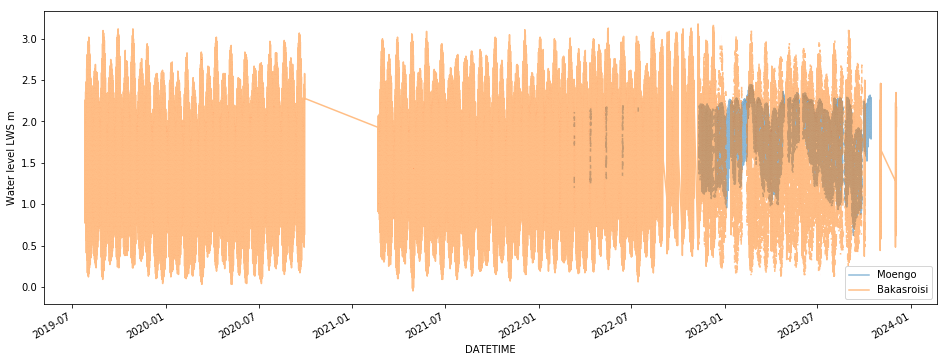

In [16]:
import pandas as pd

# Function to load and preprocess Excel data
def load_and_preprocess_excel(excel_file, header_row, date_column, value_column):
    combined_data = pd.DataFrame()
    xls = pd.ExcelFile(excel_file)

    for sheet_name in xls.sheet_names:
        df = pd.read_excel(excel_file, sheet_name=sheet_name, header=header_row,
                           usecols=[date_column, value_column])

        # Convert 'date_column' to datetime objects, handle errors, and drop invalid rows
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        df = df.dropna(subset=[date_column])

        df.set_index(date_column, inplace=True)
        combined_data = pd.concat([combined_data, df])

    return combined_data

# Specify the Excel file names and column information
excel_file_moengo = "Waterstanden_Traymorehaven_Moengo.xlsx"
header_row_moengo = 9
date_column_moengo = 'DATETIME'
value_column_moengo = 'Waterlevel  tov station in LWS m'

excel_file_bakasroisi = "Waterstanden_Bakasroisi.xlsx"
header_row_bakasroisi = 8
date_column_bakasroisi = 'DATETIME'
value_column_bakasroisi = 'Waterlevel LWS  m'

# Load and preprocess data for Moengo and Bakasroisi
moengo_data = load_and_preprocess_excel(excel_file_moengo, header_row_moengo, date_column_moengo, value_column_moengo)
bakasroisi_data = load_and_preprocess_excel(excel_file_bakasroisi, header_row_bakasroisi, date_column_bakasroisi, value_column_bakasroisi)

# Combine the data from both sources
combined_data = pd.concat([moengo_data, bakasroisi_data])

# Sort the combined_data DataFrame by date in ascending order
combined_data.sort_index(inplace=True);

# Rename columns
combined_data.rename(columns={'Waterlevel  tov station in LWS m': 'Moengo', 'Waterlevel LWS  m': 'Bakasroisi'}, inplace=True)

display(combined_data)
combined_data.plot(figsize=(16,6), marker='.', markersize=0.01, alpha=.5, ylabel='Water level LWS m');

Because of the tidal effect, modelling the behaviour of the Cottica river can be very challenging

## Storage

The storage of the catchment is simplified to the water equivalent thickness of the region. [GRACE Plotter](https://thegraceplotter.com/) uses satellite data for the computation of the storage.
This data can be used to close the water balance of the catchment.

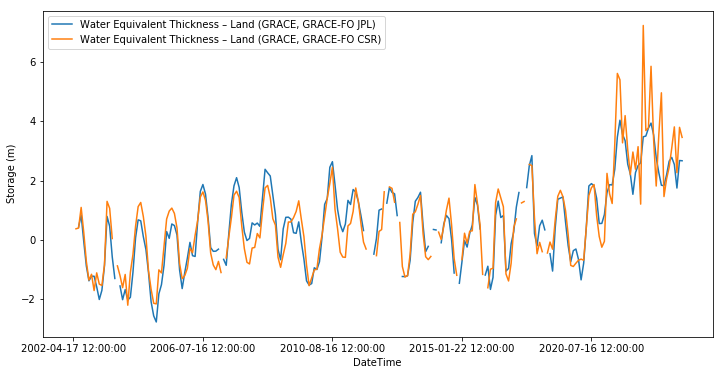

In [17]:
storage = pd.read_excel('timeSeries.water_equivalent_thickness.xlsx', header=1, index_col=0)
storage= storage/ 10
storage.plot(figsize=(12,6), ylabel='Storage (m)')

## River bed profile

![Ricanaumofo_bathykaart.png](Ricanaumofo_bathykaart.png)

These measurements were performed during the MDP in collaboration with MAS. Below we elaborate on the materials and methods of the measurements.

#### Materials
\begin{itemize}
\item Single beam echo sounder
\item GNSS GPS
\item Korjaal / boat
\item Battery
\item Sound velocity measurer SWiFT SVP Valsport
\item Toshiba Pocketbook Panasonic FZ-55
\item CEESCOPE CEE LINK-R
\item Water level gauge
\item Timer
\item Clock
\item hypack
\end{itemize}

Software
\begin{itemize}
\item QGIS
\item Python 3
\end{itemize}

#### Method
In the pursuit of gathering bathymetric data pertaining to the Cottica River in proximity to Ricanau Mofo, a collaborative effort was established with the Maritime Authority of Suriname (MAS). A local resident loaned a traditional vessel known as a 'korjaal' to facilitate the data collection process. The equipment utilised for the survey comprised a single-beam echo sounder, which was affixed to the boat via a custom-built apparatus and subsequently immersed in the water. Additionally, a Global Navigation Satellite System (GNSS) GPS device was positioned atop the echo sounder to ensure a precise correlation between depth measurements and GPS coordinates. Both the GPS and the single-beam echo sounder were interfaced with a CEESCOPE unit, facilitating real-time data acquisition and transmission to a Toshiba Pocketbook. 
Upon transmission to the laptop, the recorded measurements were imported into the computer program Hypack for subsequent analysis and processing. To power the CEESCOPE, a dedicated battery source was employed. This configuration allowed the boat's captain to plot perpendicular lines to the direction of the river's flow, thus enabling the systematic collection of cross-sectional data. Along the straight segments of the river, cross-sectional measurements were taken at intervals of 25 meters. Within the river's meandering sections, cross-sectional data was acquired at 50-meter intervals. For the purpose of tidal correction, the timestamps of each measurement were meticulously documented.
The single-beam echo sounder operated with two distinct frequencies: a 33 Hz frequency for discerning the river's hard bottom and a 200 Hz frequency for identifying the soft bottom. Sound velocity measurements were incorporated to correct the raw data for sound travel time, accounting for variations in water particle density. Given the tidal nature of the Cottica River, all collected data was standardised to the lowest water level. This was achieved by periodic readings, taken at ten-minute intervals, of the water level from a dedicated water level gauge, facilitating the identification of both high and low water levels.



The region marked in red is the region where the flow velocity was measured. The measurements were imported into GIS to create a profile map of the river. The crossectional area of the coresponding measurement cells (depended on the water level). The profile below is at the location where velocity measurements of the Cottica river were done.

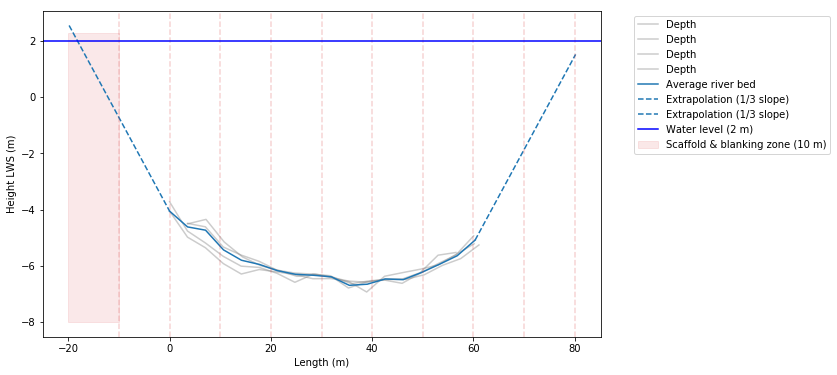

In [18]:
# Load the Excel file
excel_file = "Doorsnedes_cottica_uit_QGIS.xlsx"

# Open the Excel file
xls = pd.ExcelFile(excel_file)

# Create a figure and subplots with a larger figsize
fig, ax = plt.subplots(figsize=(10, 6)) 

# Iterate through each sheet in the Excel file
for sheet_name in xls.sheet_names[:-1]:  # Exclude the last tab ("Average")
    df = xls.parse(sheet_name)
    df = df.replace("None", np.nan)
    x, y = df['Length'], df['Depth']
    ax.plot(x, y, color='grey', alpha=0.4)

# Extract and plot the "Average" data from the last tab
average_df = xls.parse(xls.sheet_names[-1])  # Last tab ("Average")
average_x, average_y = average_df['Length'], average_df['Depth']

# Create a scatter plot for the "Average" data in color C0 and add it to the legend
average_plot, = ax.plot(average_x, average_y, label="Average river bed", color='C0')

# Note the height and length of the first and last value of the "Average" line
first_length, first_height = average_x.iloc[0], average_y.iloc[0]
last_length, last_height = average_x.iloc[-1], average_y.iloc[-1]

# Calculate extrapolation parameters
extrapolate = (100 - (last_length - first_length)) / 2
slope = 1 / 3

# Define a function to calculate the new line to be plotted
def plot_extrapolation_l(x, y, length, height, extrapolate, slope, color, label):
    left = length - extrapolate
    right = length
    x_vals = np.linspace(left, right, 50)
    y_vals = slope * (x_vals - length) + height
    ax.plot(x_vals, y_vals, linestyle='--', color=color, label=label)

def plot_extrapolation_r(x, y, length, height, extrapolate, slope, color, label):
    left = length
    right = length + extrapolate
    x_vals = np.linspace(left, right, 50)
    y_vals = slope * (x_vals - length) + height
    ax.plot(x_vals, y_vals, linestyle='--', color=color, label=label)

# Plot the extrapolation lines
plot_extrapolation_l(average_x, average_y, first_length, first_height, extrapolate, -slope, 'C0', 'Extrapolation (1/3 slope)')
plot_extrapolation_r(average_x, average_y, last_length, last_height, extrapolate, slope, 'C0', 'Extrapolation (1/3 slope)')

# Define the shaded area limits
shaded_area_start = -20
shaded_area_end = -10
segment_size = 10

# Create the shaded area with a label
ax.fill_between([shaded_area_start, shaded_area_end], -8, 2.3, color='C3', alpha=0.1, label="Scaffold & blanking zone (10 m)")

# Add vertical lines at every 10 meters
for i in range(int(shaded_area_start) + segment_size, int(90), segment_size):
    ax.axvline(x=i, color='C3', linestyle='--', alpha=0.2)

# Add a horizontal line of water level
water_level = 2
ax.axhline(water_level, color='blue', label='Water level (2 m)')

# Add labels and show the combined plot
ax.set_xlabel("Length (m)")
ax.set_ylabel("Height LWS (m)")
ax.legend(bbox_to_anchor=(1.05, 1))

# # Iterate through segments and calculate integrals
# print(f"Integral from length -10 to 0: {(4-1)*10/2+(1+water_level)*10:.2f} m^2")

# for i in range(0, 60, segment_size):
#     start_index = np.where(average_x >= i)[0][0]
#     end_index = np.where(average_x >= i + segment_size)[0][0]
#     integral = integrate.trapz(average_y[start_index:end_index + 1], average_x[start_index:end_index + 1])
#     print(f"Integral from length {i} to {i + segment_size}: {-integral + segment_size * water_level:.2f} m^2")

# print(f"Integral from length 60 to 70: {(5-2)*10/2+(2+water_level)*10:.2f} m^2")
# print(f"Integral from length 70 to 80: {(2+water_level)*10/2:.2f} m^2")

plt.show()

flow_area = [45.00, 69.99, 82.29, 87.13, 90.19, 87.22, 59.60, 55.00, 20.00]


## Flow velocities
#### Materials
\begin{itemize}
\item Side Looking Doppler (SLD) OTT
\item OTT SLD EAsyUse
\end{itemize}

Software
\begin{itemize}
\item QGIS
\item Python 3
\end{itemize}

#### Method
The river's flow velocity profile is assessed through the utilisation of a Side Looking Doppler (SLD). Notably, the SLD operates at a fixed angle of 5 degrees. Configuration settings for deployment are managed within the accompanying software program, OTT SLD Easy Use. The SLD conducts measurements at 300-second intervals and employs a 600 kHz frequency for this purpose. The measurement grid is oriented perpendicular to the river's flow direction. Each measurement cell covers a designated size of 10 meters, implying that the SLD records flow velocity readings at intervals of 10 meters, commencing from 3 meters away from the SLD due to a 3-meter blanking distance. The data output represents the average flow velocity over 120-second intervals.

Due to the tidal influence on the Cottica River, it is crucial to ensure that the Side Looking Doppler (SLD) is installed during low water levels to maintain its continuous submersion beneath the water surface. To enable ongoing measurements, it is essential to position the SLD close to the riverbed. The optimal location for SLD attachment is just before the river's bend, where the flow lines of the river run parallel to one another.

The SLD is affixed directly to an iron bar, which is, in turn, securely fastened to a wooden plank. A protective sleeve is employed to safeguard the SLD. The plank and sleeve have been estimated to be buried at a depth of approximately 20cm into the ground, with additional anchoring to the scaffold post accomplished through the use of ropes and nails. The SLD is positioned at a depth of 1.3m distance measured from the water level during low tide. To accommodate the tidal variations, measurements are conducted during both low and high spring tides. The initial measurement occurred during low spring tide on October 7, 2023, and the final measurement took place on October 29, 2023, coinciding with high spring tide.

The SLD not only measures the flow velocity of the river, but the water level as well. It uses a pressure sensor for this purpose. In combination with the earlier measured wet bathymetry a rating curve of the high water level during dry season can be set up. 


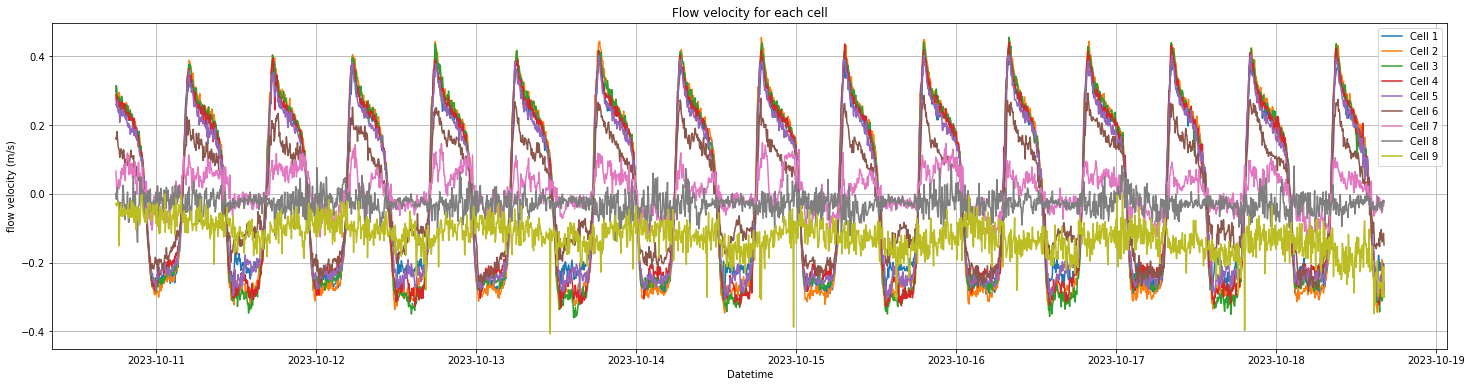

In [19]:
#loading the data
flow_velocity = np.loadtxt('M&C1001- snelheden.txt', dtype = 'float')

#make the data 2 dimensional
num_columns = 49
num_rows = int(np.size(flow_velocity) / num_columns) 
flow_velocity = flow_velocity.reshape(num_rows, num_columns)

# Define column names
columns = ["Month", "Day", "Year", "Hour", "Minute", "Second", "Error Code", "Status code", "Battery voltage", "Soundspeed", "Temperature", "Analog input 1", "Analog input 2", "Velocity Cell 1 (Beam1|X)", "Velocity Cell 1 (Beam2|Y)", "Amplitude Cell 1 (Beam1)", "Amplitude Cell 1 (Beam2)", "Velocity Cell 2 (Beam1|X)", "Velocity Cell 2 (Beam2|Y)", "Amplitude Cell 2 (Beam1)", "Amplitude Cell 2 (Beam2)","Velocity Cell 3 (Beam1|X)", "Velocity Cell 3 (Beam2|Y)", "Amplitude Cell 3 (Beam1)", "Amplitude Cell 3 (Beam2)", "Velocity Cell 4 (Beam1|X)", "Velocity Cell 4 (Beam2|Y)", "Amplitude Cell 4 (Beam1)", "Amplitude Cell 4 (Beam2)", "Velocity Cell 5 (Beam1|X)", "Velocity Cell 5 (Beam2|Y)", "Amplitude Cell 5 (Beam1)", "Amplitude Cell 5 (Beam2)", "Velocity Cell 6 (Beam1|X)", "Velocity Cell 6 (Beam2|Y)", "Amplitude Cell 6 (Beam1)", "Amplitude Cell 6 (Beam2)", "Velocity Cell 7 (Beam1|X)", "Velocity Cell 7 (Beam2|Y)", "Amplitude Cell 7 (Beam1)", "Amplitude Cell 7 (Beam2)", "Velocity Cell 8 (Beam1|X)", "Velocity Cell 8 (Beam2|Y)", "Amplitude Cell 8 (Beam1)", "Amplitude Cell 8 (Beam2)", "Velocity Cell 9 (Beam1|X)", "Velocity Cell 9 (Beam2|Y)", "Amplitude Cell 9 (Beam1)", "Amplitude Cell 9 (Beam2)"]

# Create a DataFrame
df = pd.DataFrame(flow_velocity, columns=columns)

# Combine the separate columns into a single datetime column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

plt.figure(figsize=(25, 6))
for i in range(1,10, 1):
    # Now you can plot the data
    plt.plot(df['Datetime'], df[f'Velocity Cell {i} (Beam1|X)'], label = f'Cell {i}')
    plt.xlabel('Datetime')
    plt.ylabel('flow velocity (m/s)')
    plt.title('Flow velocity for each cell')
    plt.grid(True)
    
plt.legend()
plt.show();

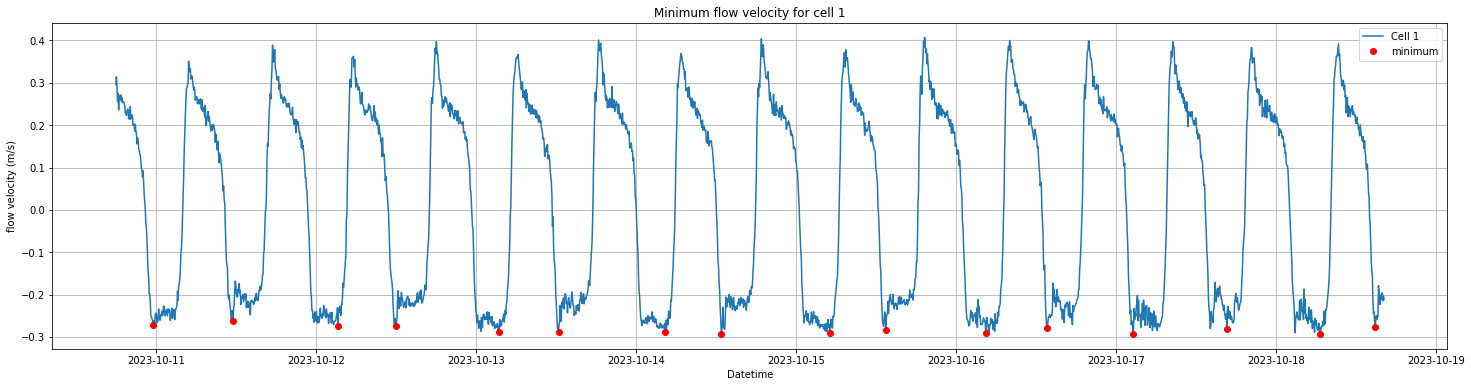

In [20]:
#defining the period to find minima in
n = 150

#find minima every 12 hours
min_velocity = df.groupby(np.arange(len(df))//n)['Velocity Cell 1 (Beam1|X)'].min()

#find the indexes of the minima every 1
min_velocity_idx = df.groupby(np.arange(len(df))//n)['Velocity Cell 1 (Beam1|X)'].idxmin()

#display the minima flow velocity data
min_data = df.iloc[min_velocity_idx]
plt.figure(figsize=(25, 6))
plt.plot(df['Datetime'], df[f'Velocity Cell 1 (Beam1|X)'], label = f'Cell 1')
plt.plot(df.iloc[min_velocity_idx]['Datetime'], df.iloc[min_velocity_idx][f'Velocity Cell 1 (Beam1|X)'], 'ro', label = f'minimum')
plt.xlabel('Datetime')
plt.ylabel('flow velocity (m/s)')
plt.title('Minimum flow velocity for cell 1')
plt.grid(True)

plt.legend()
plt.show()

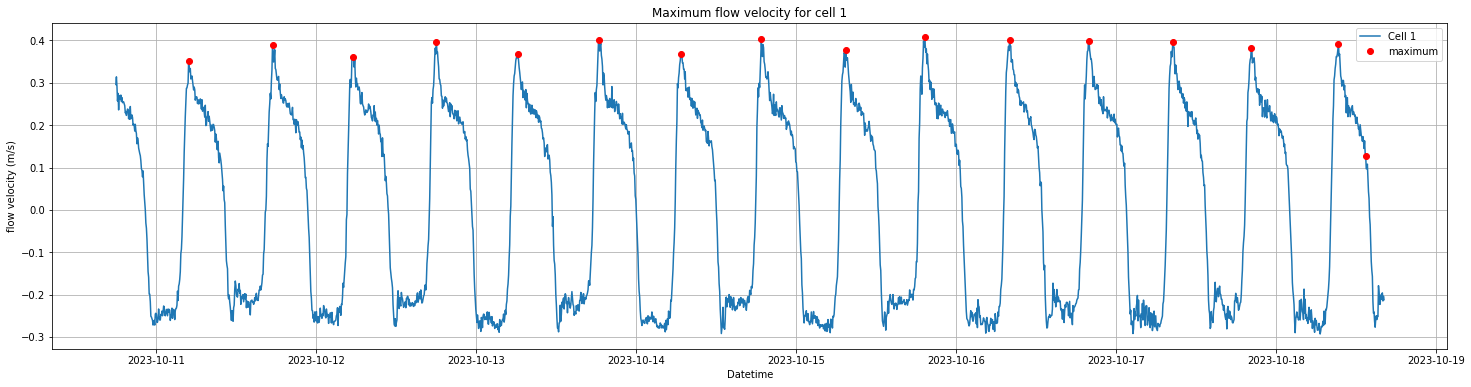

In [21]:
#defining the period to find maxima in
n = 150

#find maxima every 12 hours
max_velocity = df.groupby(np.arange(len(df))//n)['Velocity Cell 1 (Beam1|X)'].max()

#find the indexes of the maxima every 1
max_velocity_idx = df.groupby(np.arange(len(df))//n)['Velocity Cell 1 (Beam1|X)'].idxmax()

#display the maximum flow velocity data
maximum_data = df.iloc[max_velocity_idx]

plt.figure(figsize=(25, 6))
plt.plot(df['Datetime'], df[f'Velocity Cell 1 (Beam1|X)'], label = f'Cell 1')
plt.plot(df.iloc[max_velocity_idx]['Datetime'], df.iloc[max_velocity_idx][f'Velocity Cell 1 (Beam1|X)'], 'ro', label = f'maximum')
plt.xlabel('Datetime')
plt.ylabel('flow velocity (m/s)')
plt.title('Maximum flow velocity for cell 1')
plt.grid(True)

plt.legend()
plt.show()

In [22]:
max_up = []
max_down = []

Cell_area = [45.00, 69.99, 82.29, 87.13, 90.19, 87.22, 59.60, 55.00, 20.00]
index_max = np.array(max_velocity_idx)

for j in index_max:
    discharge_cell = []
    for i in range(len(Cell_area)):
        discharge_cell.append(maximum_data[f'Velocity Cell {i + 1} (Beam1|X)'][j] * Cell_area[i])

    tot_discharge_up = np.sum(discharge_cell)
    max_up.append(tot_discharge_up)

index_min = np.array(min_velocity_idx)

for j in index_min:
    discharge_cell = []
    for i in range(len(Cell_area)):
        discharge_cell.append(min_data[f'Velocity Cell {i + 1} (Beam1|X)'][j] * Cell_area[i])

    tot_discharge_down = np.sum(discharge_cell)
    max_down.append(tot_discharge_down)

print(f'The largest discharge land outward holds {-min(max_down):.1f} m^3/s and the largest velocity land inward holds {max(max_up):.1f} m^3/s')

The largest discharge land outward holds 141.5 m^3/s and the largest velocity land inward holds 179.1 m^3/s
